Random Forest regression model

Needs more work: feature engineering, etc.

In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.ensemble import RandomForestRegressor as rf
from datetime import date
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, median_absolute_error

plt.style.use('ggplot')
%matplotlib inline

In [146]:
y_data = pd.read_csv('yield_w_srad.csv')
y_data.columns

Index([u'planted', u'site', u'plot', u'rep', u'id', u'dth', u'lodging',
       u'height', u'grain_type', u'moisture', u'year', u'county',
       u'trial_type', u'yield_lb', u'head_date', u'pi', u'vg_avg_tmin',
       u'vg_avg_tmax', u'fl_avg_tmin', u'fl_avg_tmax', u'gf_avg_tmin',
       u'gf_avg_tmax', u'se_avg_tmin', u'se_avg_tmax', u'veg_srad',
       u'rep_srad', u'gf_srad'],
      dtype='object')

In [147]:
y_data.head()

,planted,site,plot,rep,id,dth,lodging,height,grain_type,moisture,...,vg_avg_tmax,fl_avg_tmin,fl_avg_tmax,gf_avg_tmin,gf_avg_tmax,se_avg_tmin,se_avg_tmax,veg_srad,rep_srad,gf_srad
0,1995-05-12,RES,349.0,1,CM101,78,15.0,85.0,S,16.0,...,28.114548,15.854166,32.492108,14.893976,33.887337,14.025759,30.655951,78968,36409,49842
1,1995-05-12,RES,374.0,2,CM101,78,15.0,80.0,S,15.9,...,28.114548,15.854166,32.492108,14.893976,33.887337,14.025759,30.655951,78968,36409,49842
2,1995-05-12,RES,8.0,1,M203,87,60.0,105.0,M,23.0,...,28.114548,16.097288,33.369639,13.492801,32.751324,13.859148,30.760579,78968,49218,47679
3,1995-05-12,RES,1096.0,1,94Y589,87,10.0,95.0,M,18.7,...,28.114548,16.097288,33.369639,13.492801,32.751324,13.859148,30.760579,78968,49218,47679
4,1995-05-12,RES,350.0,1,94Y383,86,1.0,85.0,M,19.9,...,28.114548,16.101021,33.400215,13.581463,32.705987,13.873189,30.725791,78968,47809,47944


In [148]:
#drop columns that are not required
drop_col = ['year', 'county', 'site', 'id']
y_data.drop(drop_col, axis = 1, inplace = True)
y_data['planted'] = pd.to_datetime(y_data['planted'], format = "%Y-%m-%d", infer_datetime_format = True)
y_data['head_date'] = pd.to_datetime(y_data['head_date'], format = "%Y-%m-%d", infer_datetime_format = True)

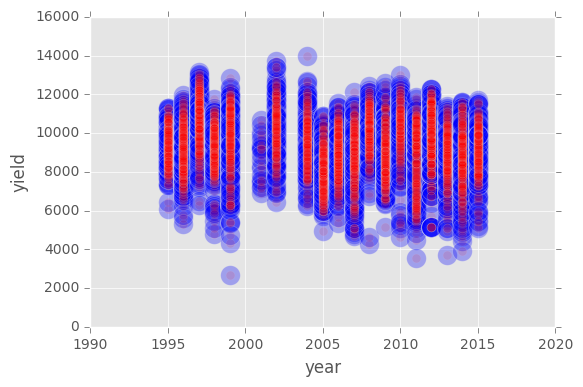

In [225]:
plt.scatter(y_data['planted'].dt.year, y_data['yield_lb'], s = 200, alpha = .3)
plt.scatter(y_data['head_date'].dt.year, y_data['yield_lb'], c = 'r', alpha = .1, label = 'head', s = 40)
plt.xlabel('year')
plt.ylabel('yield')
plt.show()

In [149]:
y_data = y_data.dropna()
y_data['trial_type'] = pd.factorize(y_data['trial_type'])[0]
y_data['grain_type'] = pd.factorize(y_data['grain_type'])[0]
y_train = y_data[y_data.planted.dt.year <= 2010]
y_test = y_data[y_data.planted.dt.year > 2010]
train_yield = y_train['yield_lb']
test_yield = y_test['yield_lb']
x_train = y_train.drop('yield_lb', axis = 1)
x_test = y_test.drop('yield_lb', axis = 1)

x_train['planted'] = x_train['planted'].apply(lambda x: x.toordinal())
x_train['head_date'] = x_train['head_date'].apply(lambda x: x.toordinal())
x_test['planted'] = x_test['planted'].apply(lambda x: x.toordinal())
x_test['head_date'] = x_test['head_date'].apply(lambda x: x.toordinal())

Random Forest training

In [228]:
for leaf_size in [1,5,10,50,100,200,500]:
    random_forest = rf(n_estimators=200, oob_score= False, random_state = 50, min_samples_leaf=leaf_size)
    random_forest.fit(x_train, train_yield)
    test_preds = random_forest.predict(x_test)
    r2 = r2_score(test_yield, test_preds)
    mse = mean_squared_error(test_yield, test_preds)
    print 'r2 = {}, MSE = {}'.format(r2, mse)

r2 = 0.159694757733, MSE = 1700967.43617
r2 = 0.126762626146, MSE = 1767629.50206
r2 = 0.121520417304, MSE = 1778240.91573
r2 = 0.0858783576729, MSE = 1850388.48752
r2 = 0.00329095400198, MSE = 2017564.02947
r2 = -0.107138824191, MSE = 2241098.82045
r2 = -0.192170262884, MSE = 2413221.64082


In [230]:
random_forest = rf(n_estimators=200, oob_score= False, random_state = 50, min_samples_leaf=1)
random_forest.fit(x_train, train_yield)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=1, oob_score=False, random_state=50,
           verbose=0, warm_start=False)

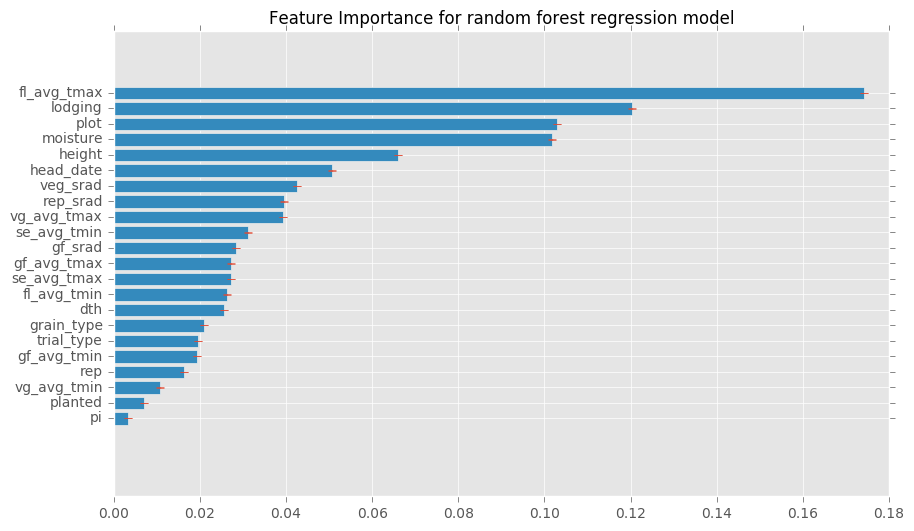

In [231]:
importance = random_forest.feature_importances_
importance = pd.DataFrame(importance, index=x_train.columns, 
                          columns=["Importance"])

importance["Std"] = np.std([tree.feature_importances_
                            for tree in random_forest.estimators_], axis=0)

x = range(importance.shape[0])
importance = importance.sort_values(by = 'Importance', ascending=True)
y = importance.ix[:, 0]
yerr = importance.ix[:, 1]

plt.figure(figsize=(10, 6))
plt.barh(x, y, yerr=yerr, align="center", )
plt.yticks(x, importance.index, rotation = 'horizontal', size = 10)
plt.title('Feature Importance for random forest regression model', size = 12)
plt.show()

## Random Forest testing

MSE = 1700967.43617


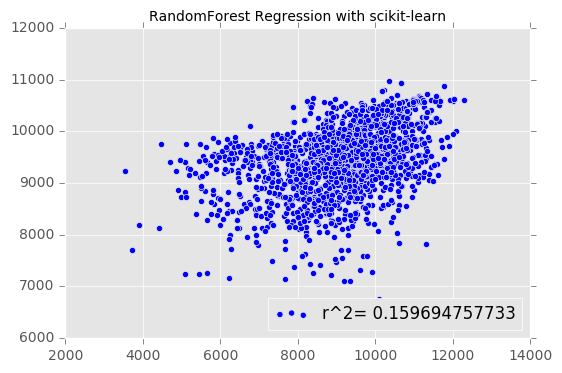

In [232]:
test_preds = random_forest.predict(x_test)
r2 = r2_score(test_yield, test_preds)
mse = mean_squared_error(test_yield, test_preds)
print 'MSE = {}'.format(mse)

plt.scatter(test_yield, test_preds, label="r^2= {}".format(r2),)
plt.legend(loc="lower right")
plt.title("RandomForest Regression with scikit-learn", size = 10)
plt.show()

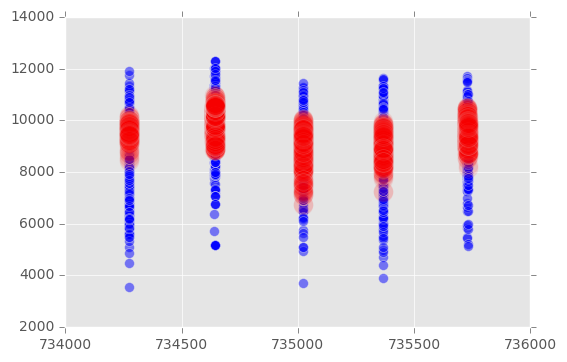

In [233]:
plt.scatter(x_test['planted'], test_yield, alpha = .5, s = 50)
plt.scatter(x_test['planted'], test_preds, c = 'r', alpha=.1, s = 200)
plt.show()